# Desription

+ Determine equalizer and show improvement in sampling points and BER

# Import

In [10]:
# importing
import numpy as np

from scipy import signal, stats

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [11]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=0)

matplotlib.rc('figure', figsize=(28, 8) )

# Initialization

### Parameters

In [12]:
# constellation points equal to BPSK
constellation = [ -1, 1 ]

# Simulation

+ T spaced equalizer
+ Note that channel impulse reponse has to be provided with the respective sampling rate

In [13]:
# snr range for simulation
snr_db_min = -2
snr_db_max = 30
snr_db_step = 2
EbN0_dB = np.arange( snr_db_min, snr_db_max + snr_db_step, snr_db_step)

EbN0 = 10**(EbN0_dB/10)

# maximum number of errors and symbols to be simulated
max_errors = 200
max_syms = 1e5


# number of symbols per sequence
# NOTE: single transmission not feasible in order to represent memory of the channel and the equalizer
n_symb = int( 1e2 )

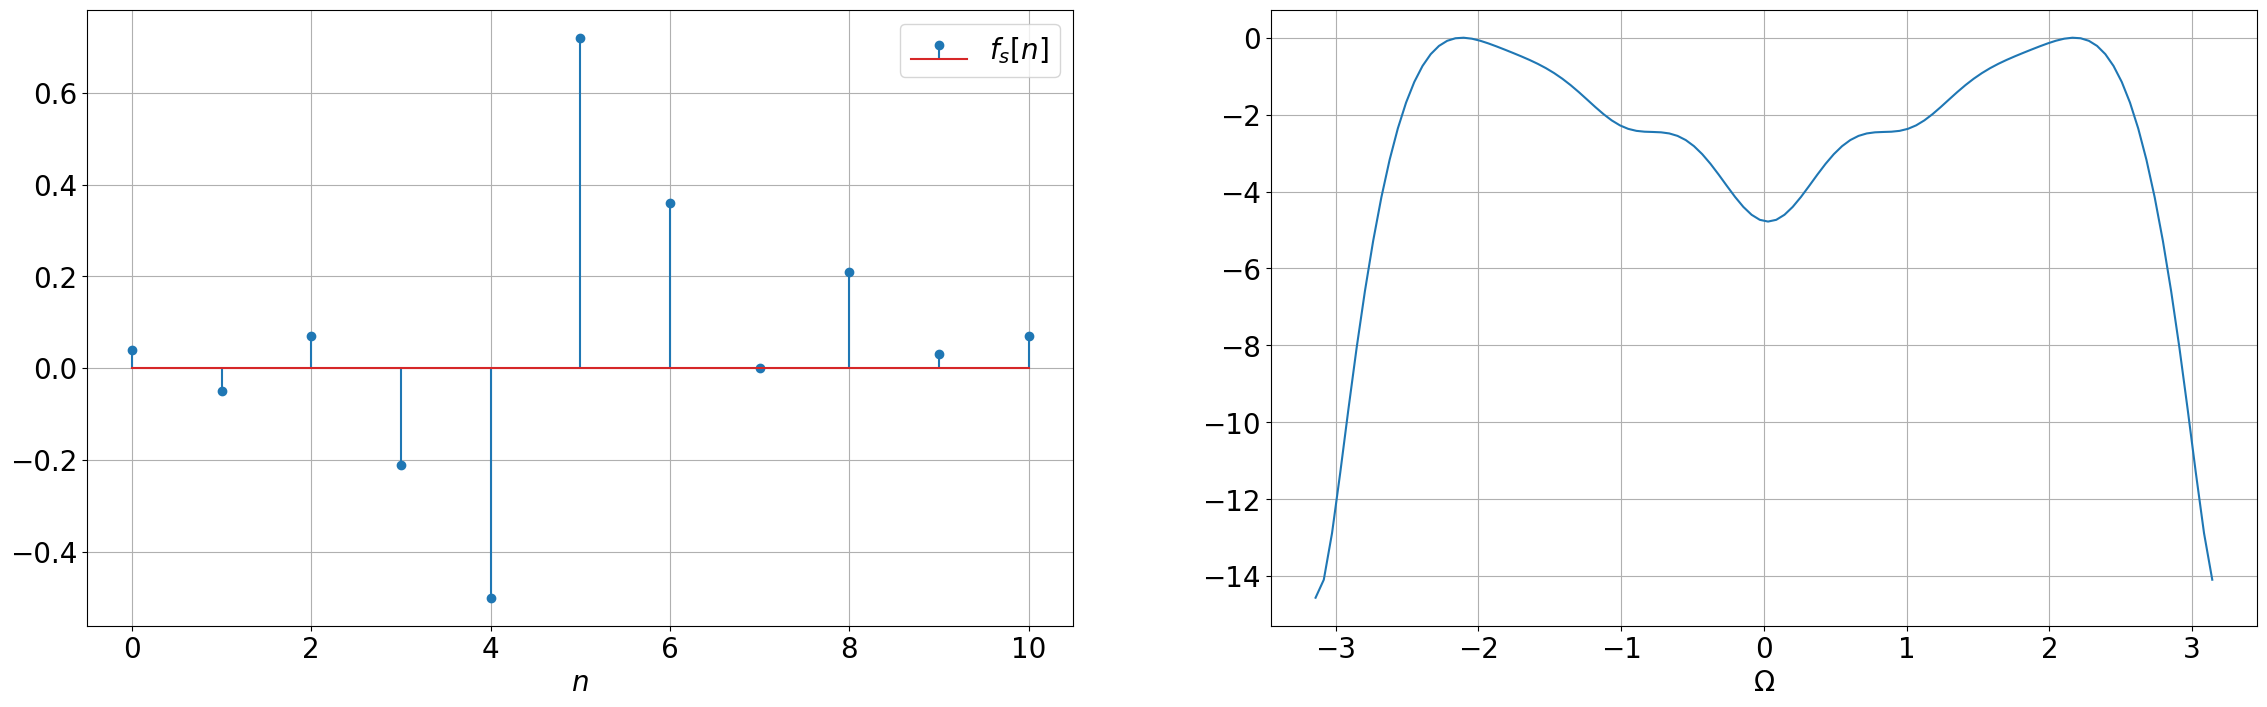

In [14]:
# channel 

# "nice" channel of motivation section
f = np.array( [1.0, 0, .5])#, 0, 0, .1] )

# "Proakis A channel"
f = np.array( [ .04, -.05, .07, -.21, -.5, .72, .36, 0, .21, .03, .07 ] )

# "Proakis B channel"
#f = np.array( [ .407, 0.815, .407 ] )

# "Proakis C channel"
#f = np.array( [ .227, .46, .688, .46, .227 ] )

# arbitrary channel
#f = np.array( [1, .4, -0.3, .1, .1, .05, .05] )

plt.subplot(121)
plt.stem(f, label='$f_s[n]$' )
plt.grid(1)
plt.xlabel('$n$')
plt.legend()


F = np.fft.fft( np.concatenate( ( f, np.zeros(9*len(f))) ) )
F /= np.max( np.abs( F ) )
Omega = np.linspace( -np.pi, np.pi, len(F) )

plt.subplot(122)
plt.plot( Omega, 10*np.log10( np.fft.fftshift( np.abs(F)**2 ) ) )
plt.grid(1)
plt.xlabel('$\\Omega$')
plt.show()

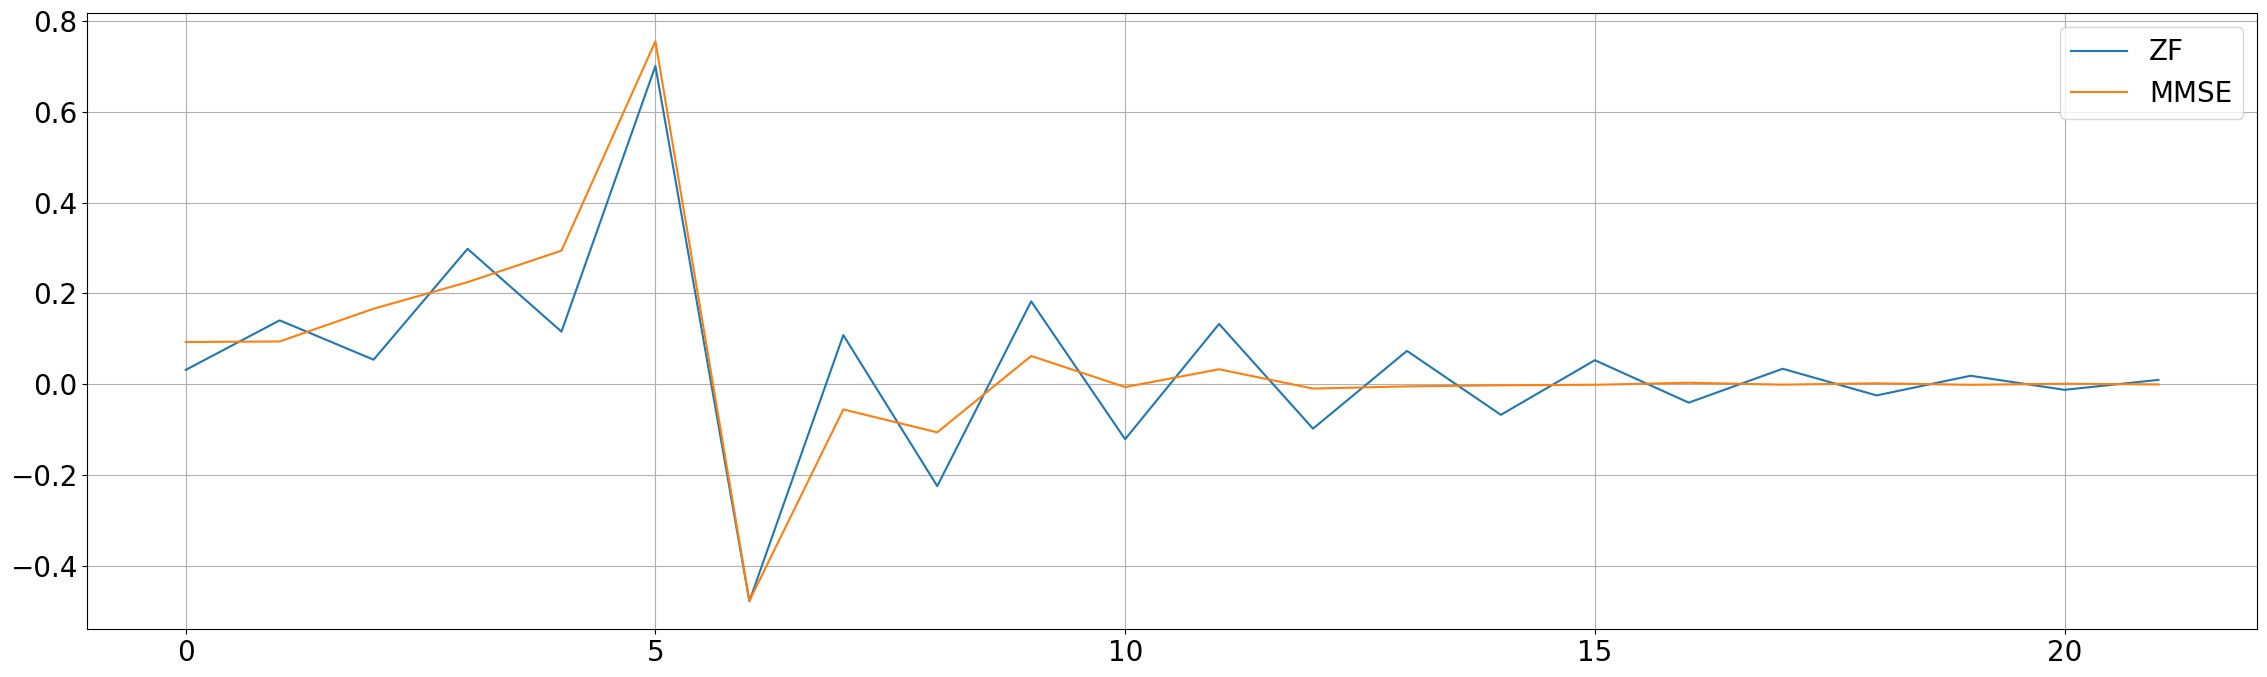

In [15]:
# determine equalizer
# NOTE: perfect CSI is assumed!


N_equalizer = 2 * len( f )
position_Dirac = N_equalizer


# get T-spaced ZF equalizer 
def get_ZF_eq( f, N_equalizer ):
    F = np.zeros( ( N_equalizer + len(f) - 1, N_equalizer ) )
    for _k in range( N_equalizer ):
        F[ _k : _k + len(f), _k ] = f

    position_Dirac = ( N_equalizer - 1 ) // 2    
    d = np.zeros( N_equalizer + len(f) - 1 )
    d[ position_Dirac ] = 1

    h_ZF = np.matmul( np.linalg.pinv( F ), d )
    h_ZF /= np.linalg.norm( h_ZF )

    return h_ZF

    
# get MMSE equalizer 
def get_MMSE_eq( f, n_symb, N_equalizer, SNR ):

    F = np.zeros( ( N_equalizer + len(f) - 1, N_equalizer ) )
    for _k in range( N_equalizer ):
        F[ _k : _k + len(f), _k ] = f


    F_inv = np.linalg.pinv( np.matmul( F.T.conj(), F ) +  1/SNR * np.eye( np.shape(F)[1] ) )

    r_xA = np.zeros( np.shape(F_inv)[0] )
    r_xA[ :len(f) ] = np.array( [f[::-1] ] ) 

    h_MMSE = np.matmul( F_inv, r_xA )
    h_MMSE /= np.linalg.norm( h_MMSE )
    
    
    #h_MMSE = np.matmul( F_temp, F )
    #F_temp = np.matmul(np.linalg.pinv( np.matmul( F,np.transpose(F) ) +  1/SNR * np.eye( np.shape(F)[0] ) ), np.conj(F))
    #h_MMSE = ((d.reshape(1,len(F))@ F_temp)).flatten()
    #h_MMSE /= np.linalg.norm( h_MMSE )

    return h_MMSE

h_ZF = get_ZF_eq( f, N_equalizer )
h_MMSE = get_MMSE_eq( f, n_symb, N_equalizer, 4 )

plt.plot( h_ZF, label='ZF')
plt.plot( h_MMSE, label='MMSE')
plt.legend()
plt.grid(1)
plt.show()

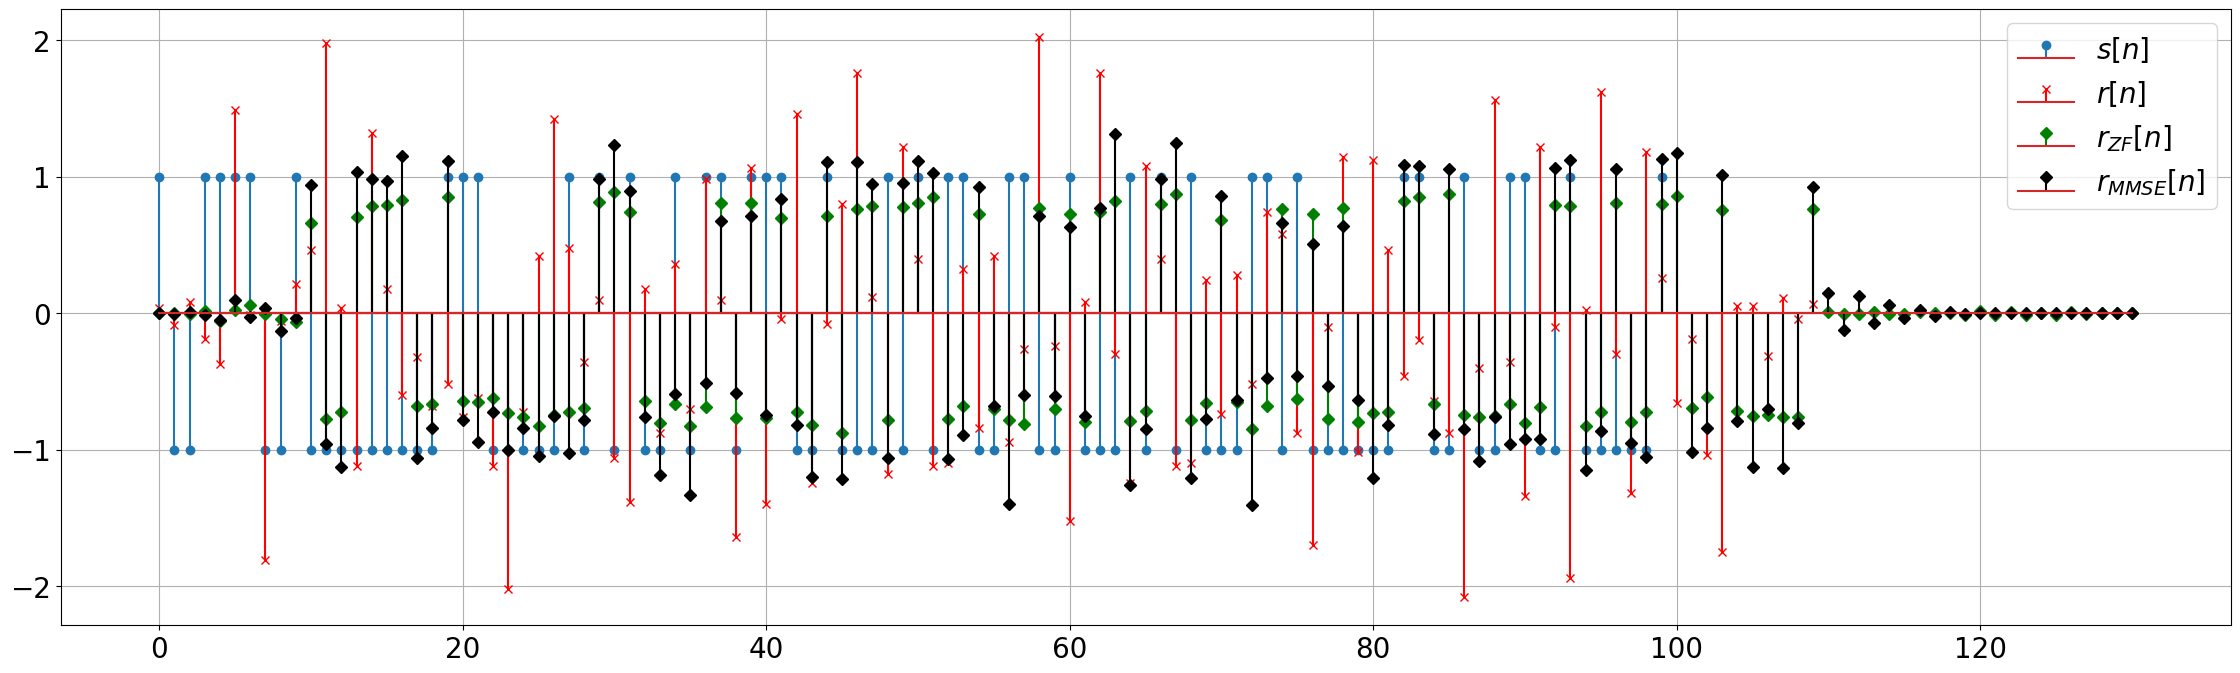

In [16]:
# generate random BPSK symbols
s = np.random.choice( constellation, n_symb )

# apply channel
s_Rx = np.convolve( s, f )   

# apply equalization
r_ZF = np.convolve( s_Rx, h_ZF )
r_MMSE = np.convolve( s_Rx, h_MMSE )

plt.stem( s, label='$s[n]$') 
plt.stem( s_Rx, 'r', markerfmt='x', label='$r[n]$') 
plt.stem( r_ZF, 'Dg', markerfmt='D', label='$r_{ZF}[n]$') 
plt.stem( r_MMSE, '+k', markerfmt='D', label='$r_{MMSE}[n]$') 

plt.grid(1)
plt.legend()
plt.show()

In [17]:
# initialize BER  and SER array with |mod| rows and |EbN0| columns
ber = np.zeros( len(EbN0) ) 
ber_ZF = np.zeros( len(EbN0) )
ber_MMSE = np.zeros( len(EbN0) )
position_Dirac = ( N_equalizer - 1 ) // 2

# loop for snrs
for ind_ebn0, val_ebn0 in enumerate( EbN0 ):
    
    num_errors = 0
    num_errors_ZF = 0
    num_errors_MMSE = 0
    num_syms = 0

    # loop for errors
    while ( num_errors_ZF < max_errors and num_syms < max_syms ):    
        
        # generate random BPSK symbols
        s = np.random.choice( constellation, n_symb )
        
        # add noise
        sigma2 = 1 / val_ebn0
        n = np.sqrt( sigma2 / 2 ) * ( np.random.randn(len(s_Rx)) + 1j* np.random.randn(len(s_Rx)) )
    
        # apply channel
        s_Rx = np.convolve( s, f )    
        r = s_Rx + n
     

        # estimation of symbols wo. using equalization
        s_est = np.sign( np.real(r) )

        # number of errors
        for _k in np.arange(len(s)):
            if not np.isclose( s_est[_k ], s[_k] ):
                num_errors += 1


        # estimation of symbols using equalization
        r_ZF = np.convolve( r, h_ZF )
        s_ZF_est = np.sign( np.real(r_ZF) )
        
        # number of errors
        for _k in np.arange(len(s)):
            if not np.isclose( s_ZF_est[_k + position_Dirac ], s[_k] ):
                num_errors_ZF += 1

        
        # estimation of symbols using equalization
        #F = np.zeros( ( N_equalizer + len(f) - 1, N_equalizer ) )
        #for _k in range( N_equalizer ):
        #    F[ _k : _k + len(f), _k ] = f

                
        #d = np.zeros( N_equalizer + len(f) - 1 )
        #d[ position_Dirac ] = 1

        #F_temp = np.matmul( np.linalg.pinv( np.matmul( F, np.transpose(F) ) +  1/SNR * np.eye( np.shape(F)[0] ) ), F )
        #h_MMSE = np.matmul( F_temp, F )
        h_MMSE = get_MMSE_eq( f, n_symb, N_equalizer, val_ebn0 )
 

        r_MMSE = np.convolve( r, h_MMSE )
        s_MMSE_est = np.sign( np.real(r_MMSE ))
        
        # number of errors
        for _k in np.arange(len(s)):
            if not np.isclose( s_MMSE_est[_k + position_Dirac ], s[_k] ):
                num_errors_MMSE += 1

    
        num_syms += n_symb

    ber[ ind_ebn0 ] = num_errors/(num_syms*1.0)
    ber_ZF[ ind_ebn0 ] = num_errors_ZF/(num_syms*1.0)
    ber_MMSE[ ind_ebn0 ] = num_errors_MMSE/(num_syms*1.0)



    print( 'EbN0 simulated:', 10*np.log10( val_ebn0 ) )


EbN0 simulated: -2.0
EbN0 simulated: 0.0
EbN0 simulated: 2.0000000000000004
EbN0 simulated: 4.0
EbN0 simulated: 6.0
EbN0 simulated: 8.0
EbN0 simulated: 10.0
EbN0 simulated: 12.0
EbN0 simulated: 14.0
EbN0 simulated: 16.0
EbN0 simulated: 18.0
EbN0 simulated: 20.0
EbN0 simulated: 22.0
EbN0 simulated: 24.0
EbN0 simulated: 26.0
EbN0 simulated: 28.0
EbN0 simulated: 30.0


### 

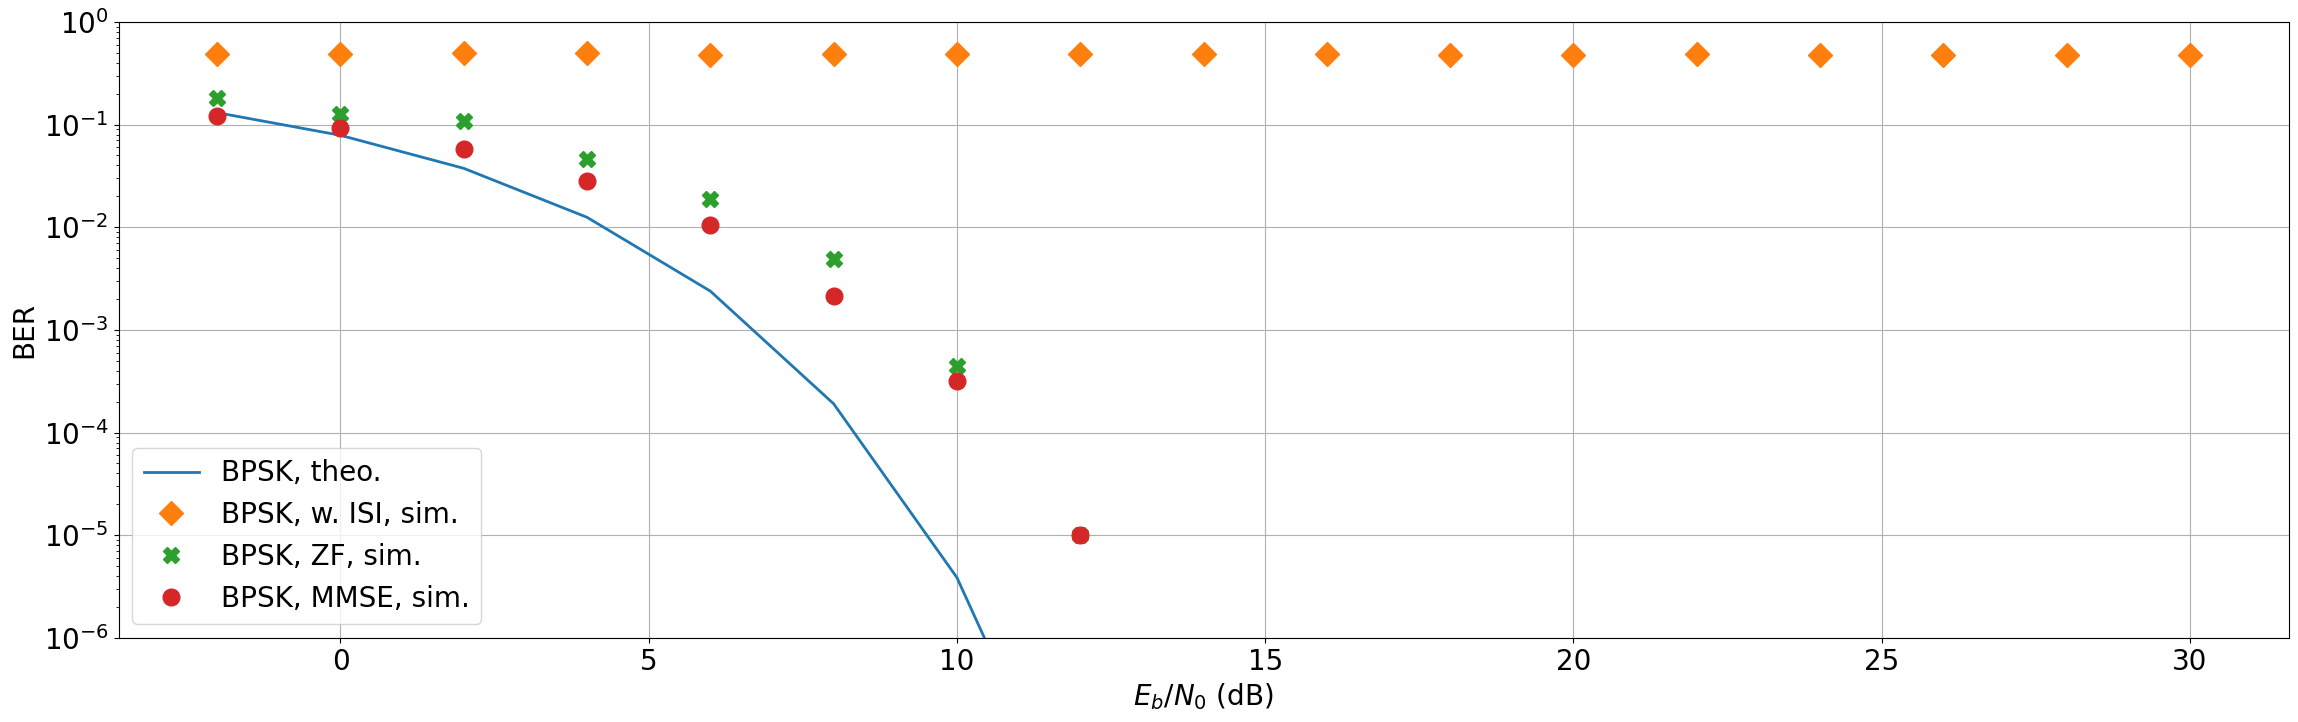

In [18]:
ber_theo = 1 - stats.norm.cdf( np.sqrt( 2 * EbN0 ) )

plt.figure()
plt.plot( EbN0_dB, ber_theo, linewidth=2.0, label = "BPSK, theo.")    
plt.plot( EbN0_dB, ber, 'D', linewidth=2.0, markersize = 12, label = "BPSK, w. ISI, sim." )    
plt.plot( EbN0_dB, ber_ZF, 'X', linewidth=2.0, markersize = 12, label = "BPSK, ZF, sim." )   
plt.plot( EbN0_dB, ber_MMSE, 'o', linewidth=2.0, markersize = 12, label = "BPSK, MMSE, sim." )    



plt.yscale('log')
plt.grid(True)
plt.legend(loc='lower left')

plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('BER')
plt.ylim( (1e-6, 1))
plt.show()